In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("MAFood121"))
#from tqdm import tqdm, tqdm_notebook
# -------------------------------------------------------------------------------------------------------------------------------

import os
import sys
import cv2
import numpy as np
import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
from torchvision import datasets, transforms
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.models import ResNet50_Weights

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(42) # try and make the results more reproducible
BASE_PATH = 'MAFood121/'

# ------------------------------------------------------------------------------------------------------------------------------
epochs = 35
batch_size = 64
MICRO_DATA = True # very small subset (just 3 groups)
SAMPLE_TRAINING = False # make train set smaller for faster iteration
IMG_SIZE = (384, 384)
# ------------------------------------------------------------------------------------------------------------------------------

#Ingredients for each class
f = open(BASE_PATH + '/annotations/foodgroups.txt', "r")
ingredients = f.read().split('\n')
f.close()
# ------------------------------------------------------------------------------------------------------------------------------
#Classes
f = open(BASE_PATH + '/annotations/dishes.txt', "r")
classes = f.read().split('\n')
f.close()
# ------------------------------------------------------------------------------------------------------------------------------
#Base Ingredients
f = open(BASE_PATH + '/annotations/baseIngredients.txt', "r") # crear baseingredients para mafood
base_ing = f.read().strip().split(', ')
f.close()
# ------------------------------------------------------------------------------------------------------------------------------
print(ingredients)
print("#######################################################################################")
print(classes)
print("#######################################################################################")
print(base_ing)

#train
f = open(BASE_PATH + '/annotations/train.txt', "r")
train_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/train_lbls_ff.txt', "r")
train_labels = f.read().split('\n')
f.close()

#val
f = open(BASE_PATH + '/annotations/val.txt', "r")
val_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/val_lbls_ff.txt', "r")
val_labels = f.read().split('\n')
f.close()

#test
f = open(BASE_PATH + '/annotations/test.txt', "r")
test_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/test_lbls_ff.txt', "r")
test_labels = f.read().split('\n')
f.close()

#train_images
len(train_labels)

train_images = ["MAFood121/images/" + s  for s in train_images]
all_img_df = pd.DataFrame({'path': train_images, 'class_id': train_labels})

val_images = ["MAFood121/images/" + s  for s in val_images]
val_img_df = pd.DataFrame({'path': val_images, 'class_id': val_labels})

test_images = ["MAFood121/images/" + s  for s in test_images]
test_img_df = pd.DataFrame({'path': test_images, 'class_id': test_labels})

all_img_df = all_img_df[:-1]
val_img_df = val_img_df[:-1]
test_img_df = test_img_df[:-1]
#print("-------------------------------------------------------------------------------------------------")

all_img_df['class_name'] = all_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
print(all_img_df)
#print("-------------------------------------------------------------------------------------------------")

val_img_df['class_name'] = val_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
print(val_img_df)
#print("-------------------------------------------------------------------------------------------------")

test_img_df['class_name'] = test_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
print(test_img_df)
#print("-------------------------------------------------------------------------------------------------")

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

#Dataframe for train
train_ingredients = []
train_classid = []
with open(BASE_PATH + '/annotations/train_lbls_ff.txt') as f1:
    for line in f1:
       idx_ingredients = []
       classid = int(line)
       train_classid.append(classid)
       for ing in ingredients[classid].strip().split(","):
           idx_ingredients.append(str(base_ing.index(ing)))
       train_ingredients.append(idx_ingredients)
    
df_train = pd.DataFrame(mlb.fit_transform(train_ingredients),columns=mlb.classes_) #binary encode ingredients
df_train["path"] = all_img_df['path']
df_train["class_id"] = train_classid 
food_dict_train = df_train
#print(df_train)

#Dataframe for train images
new_data = []
for index, row in all_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    
    binary_encod = food_dict_train.loc[food_dict_train["path"] == path]
    new_data.append(np.array(binary_encod)[0])

col_names = list(binary_encod.columns.values)
train_df = pd.DataFrame(new_data, columns = col_names)

#Dataframe for test
test_ingredients = []
test_classid = []
with open(BASE_PATH + '/annotations/test_lbls_ff.txt') as f1:
    for line in f1:
       idx_ingredients = []
       classid = int(line)
       test_classid.append(classid)
       for ing in ingredients[classid].strip().split(","):
           idx_ingredients.append(str(base_ing.index(ing)))
       test_ingredients.append(idx_ingredients)
df_test = pd.DataFrame(mlb.fit_transform(test_ingredients),columns=mlb.classes_) #binary encode ingredients
df_test["path"] = test_img_df['path']
df_test["class_id"] = test_classid
food_dict_test = df_test

#Dataframe for test images
test_data = []
for index, row in test_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict_test.loc[food_dict_test["path"] == path]
    test_data.append(np.array(binary_encod)[0])

col_names = list(binary_encod.columns.values)
test_df = pd.DataFrame(test_data, columns = col_names)

train_df.to_hdf('train_df.h5','df',mode='w',format='table',data_columns=True)
#val_df.to_hdf('val_df.h5','df',mode='w',format='table',data_columns=True)
test_df.to_hdf('test_df.h5','df',mode='w',format='table',data_columns=True)
# -------------------------------------------------------------------------------------------------------------------------------



['annotations', 'images']
['ff_egg,ff_fried_food,ff_vegetable', 'ff_egg,ff_seafood,ff_vegetable', 'ff_bread,ff_meat,ff_vegetable', 'ff_rice,ff_seafood,ff_soup,ff_vegetable', 'ff_fried_food,ff_soup', 'ff_fried_food,ff_rice,ff_seafood,ff_vegetable', 'ff_bread,ff_egg,ff_fried_food', 'ff_egg', 'ff_egg,ff_meat,ff_noodles/pasta,ff_rice,ff_vegetable', 'ff_meat,ff_rice,ff_vegetable', 'ff_rice,ff_vegetable', 'ff_bread,ff_meat,ff_seafood,ff_vegetable', 'ff_noodles/pasta,ff_seafood,ff_soup', 'ff_egg,ff_rice,ff_vegetable', 'ff_fried_food,ff_meat,ff_rice,ff_vegetable', 'ff_meat,ff_rice,ff_soup', 'ff_fried_food,ff_rice,ff_vegetable', 'ff_fried_food,ff_meat,ff_rice', 'ff_bread,ff_noodles/pasta,ff_seafood,ff_soup,ff_vegetable', 'ff_meat,ff_rice,ff_seafood,ff_vegetable', 'ff_noodles/pasta,ff_seafood', 'ff_egg,ff_meat,ff_soup,ff_vegetable', 'ff_dumpling', 'ff_fried_food,ff_seafood,ff_vegetable', 'ff_fried_food,ff_vegetable', 'ff_egg,ff_soup', 'ff_egg,ff_meat,ff_rice,ff_vegetable', 'ff_bread,ff_egg,ff_so

C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work

In [26]:
col_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'path', 'class_id']

In [32]:
train_df

0  1  2  3  4  5  6  7  8  9  \
0      0  0  0  0  0  0  0  1  0  0   
1      0  0  0  0  1  1  0  0  1  1   
2      0  0  0  0  1  0  0  0  0  1   
3      0  0  0  0  1  1  0  0  0  0   
4      1  0  1  0  1  0  0  0  0  0   
...   .. .. .. .. .. .. .. .. .. ..   
15292  0  0  0  0  0  0  0  1  0  0   
15293  1  0  0  0  0  1  0  0  0  1   
15294  0  0  0  1  1  0  0  0  0  1   
15295  0  0  1  0  1  0  1  0  0  1   
15296  1  0  1  0  0  0  0  0  0  0   

                                                path  class_id  
0              MAFood121/images/takoyaki/3846185.jpg       103  
1                   MAFood121/images/pho/1002382.jpg       149  
2        MAFood121/images/beef_carpaccio/1636003.jpg        37  
3               MAFood121/images/lasagna/2991997.jpg       117  
4         MAFood121/images/croque_madame/2879957.jpg        41  
...                                              ...       ...  
15292          MAFood121/images/takoyaki/1010258.jpg       103  
15293  MAFood121/images/steamed_rice_roll/162847.jpg        64  
15294     MAFood121/images/confit_de_canard/30_1.jpg       171  
15295    MAFood121/images/stewed_pork_leg/181972.jpg        26  
15296     MAFood121/images/croque_madame/3584334.jpg       156  

[15297 rows x 12 columns]

['artichoke_bottoms_in_olive_oil', 'baby_back_ribs', 'banh_mi', 'banh_xeo', 'beef_bourguignon', 'beef_carpaccio', 'beef_in_oyster_sauce', 'biryani', 'blanquette_de_veau', 'borek', 'breakfast_burrito', 'bruschetta', 'bun_cha', 'butter_chicken', 'caesar_salad', 'cao_lau', 'caprese_salad', 'charcoal-boiled_pork_neck', 'cha_ca', 'chicken_quesadilla', 'chilaquiles', 'chiles_en_nogada', 'chole', 'chow_mein', 'cig_kofte', 'clam_chowder', 'club_sandwich', 'coconut_milk-flavored_crepes_with_shrimp_and_beef', 'coconut_milk_soup', 'com_tam', 'confit_de_canard', 'coq_au_vin', 'croque_madame', 'eggs_benedict', 'enchiladas', 'foie_gras', 'french_onion_soup', 'fried_mussel_pancakes', 'fried_pork_in_scoop', 'gnocchi', 'goya_champuru', 'greek_salad', 'green_curry', 'guacamole', 'gyro', 'hamburger', 'hamsi', 'hot_and_sour_fish_and_vegetable_ragout', 'hot_and_sour_soup', 'huevos_rancheros', 'hue_beef_rice_vermicelli_soup', 'hunkar_begendi', 'icli_kofte', 'ispanak', 'kaali_daal', 'kebap', 'khao_soi', 'kis

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  0



Training:  27%|██▋       | 260/957 [01:53<04:48,  2.41it/s]


Training:  54%|█████▍    | 520/957 [04:11<07:46,  1.07s/it]


Training:  82%|████████▏ | 780/957 [07:05<01:05,  2.71it/s]


Training: 100%|██████████| 957/957 [08:13<00:00,  1.94it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.01703210826189976  train acc:  0.8867947963653003



Testing: 100%|██████████| 199/199 [01:09<00:00,  2.85it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ True False False ... False False  True]
 [False False False ... False False False]
 [False False False ... False  True False]
 ...
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 [ True False False ... False False  True]]
[[ True False False ... False False  True]
 [False  True False ... False False False]
 [False False False ... False False False]
 ...
 [ True False False ... False False  True]
 [ True False False ... False False False]
 [ True False False ... False False  True]]
Test set accuracy:  0.9089420654911838


Epochs:  10%|█         | 1/10 [09:23<1:24:30, 563.44s/it]

Epoch  1



Training:  27%|██▋       | 260/957 [01:27<03:54,  2.98it/s]


Training:  54%|█████▍    | 520/957 [02:53<02:24,  3.02it/s]


Training:  82%|████████▏ | 780/957 [04:20<00:57,  3.07it/s]


Training: 100%|██████████| 957/957 [05:20<00:00,  2.99it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.011985352282945866  train acc:  0.9220566124076617



Testing: 100%|██████████| 199/199 [00:55<00:00,  3.60it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epochs:  20%|██        | 2/10 [15:39<1:00:26, 453.28s/it]

[[False False False ... False False False]
 [False False False ... False False  True]
 [False False False ... False False False]
 ...
 [False False False ... False False  True]
 [False False False ... False False  True]
 [False False False ... False  True False]]
[[False False False ... False False False]
 [False False False ... False False  True]
 [False False False ... False False False]
 ...
 [False False False ... False False  True]
 [False False False ... False False  True]
 [False False False ... False  True False]]
Test set accuracy:  0.922323677581864
Epoch  2



Training:  27%|██▋       | 260/957 [01:25<03:47,  3.06it/s]


Training:  54%|█████▍    | 520/957 [02:53<02:22,  3.07it/s]


Training:  82%|████████▏ | 780/957 [04:19<00:58,  3.03it/s]


Training: 100%|██████████| 957/957 [05:17<00:00,  3.01it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.009252609292613515  train acc:  0.9413349022684186



Testing: 100%|██████████| 199/199 [00:54<00:00,  3.66it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epochs:  30%|███       | 3/10 [21:51<48:33, 416.27s/it]  

[[False False False ... False False  True]
 [ True False False ... False False  True]
 [False False False ... False False False]
 ...
 [False False False ... False  True False]
 [False False False ... False False  True]
 [False False False ... False  True  True]]
[[False False False ... False False  True]
 [ True False  True ... False False  True]
 [ True False False ... False False False]
 ...
 [False False False ... False  True False]
 [False False False ... False False  True]
 [False False False ... False  True  True]]
Test set accuracy:  0.923331234256927
Epoch  3



Training:  27%|██▋       | 260/957 [01:26<03:45,  3.09it/s]


Training:  54%|█████▍    | 520/957 [02:52<02:23,  3.04it/s]


Training:  82%|████████▏ | 780/957 [04:18<00:58,  3.02it/s]


Training: 100%|██████████| 957/957 [05:17<00:00,  3.02it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.006688054971630226  train acc:  0.9582859384192979



Testing: 100%|██████████| 199/199 [00:53<00:00,  3.71it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epochs:  40%|████      | 4/10 [28:03<39:51, 398.57s/it]

[[False False False ... False False False]
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 ...
 [False False  True ...  True False  True]
 [ True False False ... False False  True]
 [ True False False ... False False  True]]
[[False False False ... False False False]
 [ True False False ... False False  True]
 [ True False  True ... False False  True]
 ...
 [False False  True ...  True False  True]
 [ True False False ... False False  True]
 [False False False ... False False  True]]
Test set accuracy:  0.9291246851385391
Epoch  4



Training:  27%|██▋       | 260/957 [01:25<03:45,  3.09it/s]


Training:  54%|█████▍    | 520/957 [02:50<02:22,  3.06it/s]


Training:  82%|████████▏ | 780/957 [04:19<01:02,  2.84it/s]


Training: 100%|██████████| 957/957 [05:18<00:00,  3.01it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.004726127817381276  train acc:  0.9710531476760149



Testing: 100%|██████████| 199/199 [00:53<00:00,  3.69it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epochs:  50%|█████     | 5/10 [34:15<32:25, 389.14s/it]

[[ True False False ... False False False]
 [False False False ... False  True False]
 [False False False ... False False False]
 ...
 [ True False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
[[ True False False ... False False False]
 [False False False ... False  True False]
 [False False False ... False False  True]
 ...
 [ True False False ...  True False False]
 [ True False False ... False  True False]
 [False False False ... False False  True]]
Test set accuracy:  0.9289357682619648
Epoch  5



Training:  27%|██▋       | 260/957 [01:27<03:51,  3.01it/s]


Training:  54%|█████▍    | 520/957 [02:53<02:20,  3.10it/s]


Training:  82%|████████▏ | 780/957 [04:19<00:57,  3.10it/s]


Training: 100%|██████████| 957/957 [05:18<00:00,  3.00it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.0032655422397324632  train acc:  0.9812969863371903



Testing: 100%|██████████| 199/199 [00:54<00:00,  3.64it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epochs:  60%|██████    | 6/10 [40:29<25:35, 383.83s/it]

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False  True]
 ...
 [ True False False ... False False  True]
 [False False False ... False False  True]
 [ True False False ... False False  True]]
[[False False False ... False False False]
 [False False False ... False False  True]
 [False False False ... False False  True]
 ...
 [ True False  True ... False False  True]
 [False False False ...  True False  True]
 [ True False False ... False False  True]]
Test set accuracy:  0.9266057934508816
Epoch  6



Training:  27%|██▋       | 260/957 [01:30<04:04,  2.85it/s]


Training:  54%|█████▍    | 520/957 [02:59<02:45,  2.64it/s]


Training:  82%|████████▏ | 780/957 [04:28<01:00,  2.92it/s]


Training: 100%|██████████| 957/957 [05:29<00:00,  2.90it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.002499941003188562  train acc:  0.9860887755769105



Testing: 100%|██████████| 199/199 [00:55<00:00,  3.56it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epochs:  70%|███████   | 7/10 [46:54<19:13, 384.45s/it]

[[False False False ... False False  True]
 [False False False ... False False  True]
 [False False False ... False  True False]
 ...
 [False  True False ... False False False]
 [False False False ... False False  True]
 [False False False ... False  True  True]]
[[False False False ... False False  True]
 [False False False ... False False  True]
 [False False False ... False  True False]
 ...
 [False  True False ...  True False False]
 [False False False ... False False  True]
 [False False  True ... False  True False]]
Test set accuracy:  0.9256612090680101
Epoch  7



Training:  27%|██▋       | 260/957 [01:28<03:55,  2.97it/s]


Training:  54%|█████▍    | 520/957 [02:57<02:31,  2.88it/s]


Training:  82%|████████▏ | 780/957 [04:26<01:00,  2.93it/s]


Training: 100%|██████████| 957/957 [05:27<00:00,  2.93it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.001959566720562577  train acc:  0.9894358370922403



Testing: 100%|██████████| 199/199 [00:55<00:00,  3.60it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epochs:  80%|████████  | 8/10 [53:17<12:47, 383.89s/it]

[[ True False False ... False False  True]
 [False False False ... False False False]
 [False  True False ... False False False]
 ...
 [False False  True ... False False False]
 [False False False ... False  True  True]
 [False False  True ... False  True  True]]
[[ True False  True ... False False  True]
 [False False False ... False False False]
 [False  True False ... False False False]
 ...
 [ True False  True ... False False False]
 [False False False ... False  True  True]
 [False False  True ... False  True  True]]
Test set accuracy:  0.9280856423173803
Epoch  8



Training:  27%|██▋       | 260/957 [01:27<03:59,  2.91it/s]


Training:  54%|█████▍    | 520/957 [02:54<02:25,  3.01it/s]


Training:  82%|████████▏ | 780/957 [04:21<00:57,  3.06it/s]


Training: 100%|██████████| 957/957 [05:19<00:00,  2.99it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.0015884584514622073  train acc:  0.9914493037850559



Testing: 100%|██████████| 199/199 [00:54<00:00,  3.65it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epochs:  90%|█████████ | 9/10 [59:31<06:20, 380.89s/it]

[[False  True False ... False False False]
 [False False False ... False False  True]
 [False False False ...  True False False]
 ...
 [False False False ... False False  True]
 [ True False False ... False False False]
 [False False False ... False False False]]
[[False  True False ... False False False]
 [ True False False ... False False  True]
 [False False False ...  True False False]
 ...
 [False False False ... False False  True]
 [ True False False ... False False False]
 [False False False ... False False False]]
Test set accuracy:  0.9210012594458439
Epoch  9



Training:  27%|██▋       | 260/957 [01:26<03:51,  3.02it/s]


Training:  54%|█████▍    | 520/957 [02:52<02:37,  2.78it/s]


Training:  82%|████████▏ | 780/957 [04:18<00:57,  3.09it/s]


Training: 100%|██████████| 957/957 [05:16<00:00,  3.03it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.001447795151201417  train acc:  0.9922533830162777



Testing: 100%|██████████| 199/199 [00:53<00:00,  3.72it/s]
C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epochs: 100%|██████████| 10/10 [1:05:41<00:00, 394.18s/it]


[[False False False ... False False  True]
 [False  True False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True  True False]
 [False  True False ... False False False]
 [False False  True ... False False  True]]
[[ True False False ... False False  True]
 [False  True False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True  True False]
 [False  True False ... False False False]
 [ True False  True ... False False False]]
Test set accuracy:  0.9254408060453401
TRAIN
F1 Samples:  [0.6259769361259849, 0.7608196336868626, 0.8265671970123823, 0.8806500600283694, 0.9173768899597493, 0.9463701773664511, 0.9609352285073015, 0.9702440876984905, 0.975692038380801, 0.9776076022791065]
F1 Weighted:  [0.6579833115969416, 0.7840113552913094, 0.8428071826983231, 0.8905989159544132, 0.9251281247636072, 0.9519266762681583, 0.9644570319263958, 0.9730538603426253, 0.9782087186129743, 0.9802700742213669]

Testing:   0%|          | 0/199 [00:00<?, ?it/s]

C:\Users\danie\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TEST
F1 Samples:  0.7984434348886491
F1 Weighted:  0.8095306421238251
Hamming:  0.7373897984886649


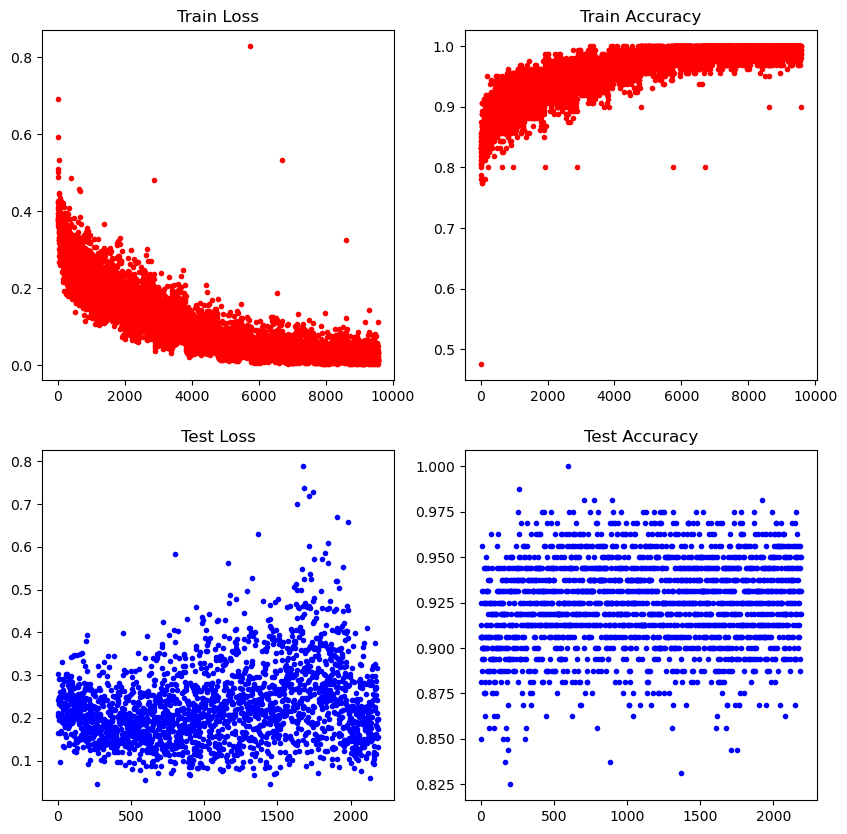

In [3]:
#START HERE
import torchvision.models as models
#from tqdm.notebook import tqdm #, tqdm_notebook, tnrange
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook, trange as tnrange
#use_cuda = False
#device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(42) # try and make the results more reproducible
BASE_PATH = 'MAFood121/'

print(os.listdir("MAFood121/images"))
epochs = 10
batch_size = 16
SMALL_DATA = False
IMG_SIZE = (384, 384)

train_df = pd.read_hdf("train_df.h5")
val_df = pd.read_hdf("test_df.h5")
test_df = pd.read_hdf("test_df.h5")

if SMALL_DATA:
    train_df = train_df[:128]
    val_df = test_df[:128]
    test_df = test_df[:128]

col_names = list(train_df.columns.values)

ing_names = col_names[:-2]
targets = ing_names

# -------------------------------------------------------------------------------------------------------------------------------

class DataWrapper(data.Dataset):
    ''' Data wrapper for pytorch's data loader function '''
    def __init__(self, image_df, resize):
        self.dataset = image_df
        self.resize = resize

    def __getitem__(self, index):
        c_row = self.dataset.iloc[index]
        target_arr = []
        for item in c_row[targets].values:
            target_arr.append(item)

        image_path, target = c_row['path'], torch.from_numpy(np.array(target_arr)).float()  #image and target
        #read as rgb image, resize and convert to range 0 to 1
        image = cv2.imread(image_path, 1)
        if self.resize:
            image = cv2.resize(image, IMG_SIZE)/255.0 
        else:
            image = image/255.0
        image = (torch.from_numpy(image.transpose(2,0,1))).float() #NxCxHxW
        return image, target

    def __len__(self):
        return self.dataset.shape[0]
    
# -------------------------------------------------------------------------------------------------------------------------------

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(targets))

ct = 0
for name, child in model.named_children():
    ct += 1
    if ct < 8:
        for name2, params in child.named_parameters():
            params.requires_grad = False
# -------------------------------------------------------------------------------------------------------------------------------

import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_dataset = DataWrapper(train_df, True)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True, batch_size=batch_size, pin_memory=False)

val_dataset = DataWrapper(val_df, True)
val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=True, batch_size=batch_size, pin_memory=False)

test_dataset = DataWrapper(test_df, True)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True, batch_size=batch_size, pin_memory=False)

# -------------------------------------------------------------------------------------------------------------------------------

#TRY LATER
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

# -------------------------------------------------------------------------------------------------------------------------------

from collections import defaultdict
train_results = defaultdict(list)
train_iter, test_iter, best_acc = 0,0,0
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
ax1.set_title('Train Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Test Loss')
ax4.set_title('Test Accuracy')

f1_scores = defaultdict(list)

for i in tqdm(range(epochs), desc='Epochs'):
    print("Epoch ",i)

    model.train() 
   
    all_outputs = []
    all_targets = []
    # Running through all mini batches in the dataset
    count, loss_val, correct, total = train_iter, 0, 0, 0
    with tqdm(train_loader, desc='Training', total=len(train_loader), miniters=1) as pbar:
        for img_data, target in pbar:
            img_data, target = img_data.to(device), target.to(device)
            output = model(img_data) #FWD prop

            loss = criterion(output, target) #Cross entropy loss
            c_loss = loss.data.item()
            ax1.plot(count, c_loss, 'r.')
            loss_val += c_loss

            optimizer.zero_grad() #Zero out any cached gradients
            loss.backward() #Backward pass
            optimizer.step() #Update the weights

            total_batch = (target.size(0) * target.size(1))
            total += total_batch
            output_data = torch.sigmoid(output)>=0.5
            target_data = (target==1.0)
            for arr1,arr2 in zip(output_data, target_data):
                all_outputs.append(list(arr1.cpu().numpy()))
                all_targets.append(list(arr2.cpu().numpy()))
            c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
            ax2.plot(count, c_acc/total_batch, 'r.')
            correct += c_acc
            count +=1
        
    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)
    f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
    f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
    recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)
    
    f1_scores["samples_train"].append(f1score_samples)
    f1_scores["macro_train"].append(f1score_macro)
    f1_scores["weighted_train"].append(f1score_weighted)
    f1_scores["hamming_train"].append(hamming)
    
    train_loss_val, train_iter, train_acc = loss_val/len(train_loader.dataset), count, correct/float(total)
    
    print("Training loss: ", train_loss_val, " train acc: ",train_acc)    
    
    ## Test Phase    
    #Model switches to test phase
    model.eval()
    
    all_outputs = []
    all_targets = []
    
    #Running through all mini batches in the dataset
    count, correct, total, lost_val = test_iter, 0, 0, 0
    for img_data, target in tqdm(val_loader, desc='Testing', total=len(val_loader)):
        img_data, target = img_data.to(device), target.to(device)
        output = model(img_data)
        loss = criterion(output, target) #Cross entropy loss
        c_loss = loss.data.item()
        ax3.plot(count, c_loss, 'b.')
        loss_val += c_loss
        
        #Compute accuracy
        total_batch = (target.size(0) * target.size(1))
        total += total_batch
        output_data = torch.sigmoid(output)>=0.5
        target_data = (target==1.0)
        for arr1,arr2 in zip(output_data, target_data):
            all_outputs.append(list(arr1.cpu().numpy()))
            all_targets.append(list(arr2.cpu().numpy()))
        c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
        ax4.plot(count, c_acc/total_batch, 'b.')
        correct += c_acc
        count += 1
    
    #F1 Score
    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)
    print(all_outputs)
    print(all_targets)
    f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
    f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
    recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)
    
    f1_scores["samples_test"].append(f1score_samples)
    f1_scores["macro_test"].append(f1score_macro)
    f1_scores["weighted_test"].append(f1score_weighted)
    f1_scores["hamming_test"].append(hamming)
    
    #Accuracy over entire dataset
    test_acc, test_iter, test_loss_val = correct/float(total), count, loss_val/len(test_loader.dataset)
    print("Test set accuracy: ",test_acc)
    
    train_results['epoch'].append(i)
    train_results['train_loss'].append(train_loss_val)
    train_results['train_acc'].append(train_acc)
    train_results['train_iter'].append(train_iter)
    
    train_results['test_loss'].append(test_loss_val)
    train_results['test_acc'].append(test_acc)
    train_results['test_iter'].append(test_iter)
    
    #Save model with best accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth') 
fig.savefig('train_curves.png')

# -------------------------------------------------------------------------------------------------------------------------------

print("TRAIN")
print("F1 Samples: ", f1_scores["samples_train"])
print("F1 Weighted: ", f1_scores["weighted_train"])
print("Hamming: ", f1_scores["hamming_train"])
print()
print("==============")
print("VALIDATION")
print("F1 Samples: ", f1_scores["samples_test"])
print("F1 Weighted: ", f1_scores["weighted_test"])
print("Hamming: ", f1_scores["hamming_test"])

# -------------------------------------------------------------------------------------------------------------------------------

#Inference on test
model_path = "best_model.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

#Run predictions
all_outputs = []
all_targets = []
for img_data, target in tqdm_notebook(test_loader, desc='Testing'):
    img_data, target = img_data.to(device), target.to(device)
    output = model(img_data)
    loss = criterion(output, target) #Cross entropy loss
    c_loss = loss.data.item()
    ax3.plot(count, c_loss, 'b.')
    loss_val += c_loss
    total_batch = (target.size(0) * target.size(1))
    total += total_batch
    output_data = torch.sigmoid(output)>=0.5
    target_data = (target==1.0)
    for arr1,arr2 in zip(output_data, target_data):
        all_outputs.append(list(arr1.cpu().numpy()))
        all_targets.append(list(arr2.cpu().numpy()))
    c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
    ax4.plot(count, c_acc/total_batch, 'b.')
    correct += c_acc
    count += 1

#F1 Score
all_outputs = np.array(all_outputs)
all_targets = np.array(all_targets)
f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)

# -------------------------------------------------------------------------------------------------------------------------------

print("TEST")
print("F1 Samples: ", f1score_samples)
print("F1 Weighted: ", f1score_weighted)
print("Hamming: ", hamming)

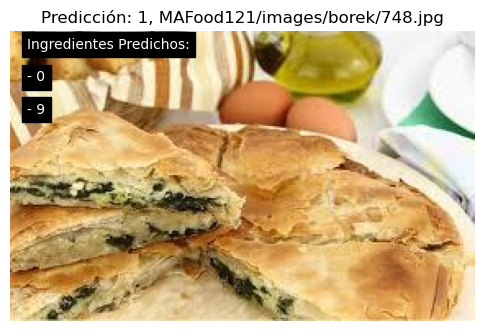

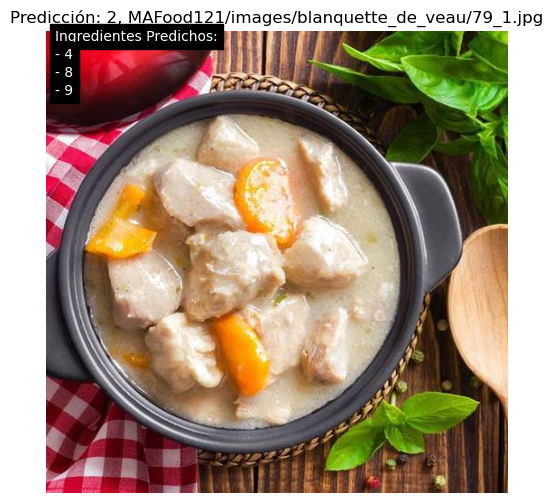

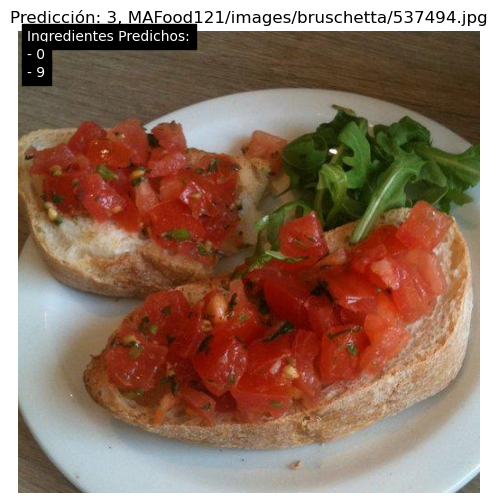

In [4]:
import random
import matplotlib.pyplot as plt

# Inference on test
model_path = "best_model.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

# Tomar tres imágenes al azar del conjunto de pruebas
random.seed(42)  # Puedes cambiar la semilla si deseas obtener diferentes imágenes al azar
random_indices = random.sample(range(len(test_df)), 3)

for i, idx in enumerate(random_indices):
    img_data, target = test_dataset[idx]
    img_data = img_data.unsqueeze(0).to(device)
    output = model(img_data)
    output_data = torch.sigmoid(output) >= 0.5
    predicted_ingredients = [ing_names[j] for j in range(len(ing_names)) if output_data[0][j].item() == 1.0]

    # Obtener el nombre de la imagen
    image_name = test_df.iloc[idx]['path']

    # Mostrar la imagen y la lista de ingredientes predichos
    image_path = test_df.iloc[idx]['path']
    image = cv2.imread(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicción: {i + 1}, {image_name}")
    plt.axis('off')
    
    if predicted_ingredients:
        plt.text(10, 10, "Ingredientes Predichos:", color='white', backgroundcolor='black', fontsize=10)
        for j, ingredient in enumerate(predicted_ingredients):
            plt.text(10, 30 + j * 20, f"- {ingredient}", color='white', backgroundcolor='black', fontsize=10)
    else:
        plt.text(10, 30, "No se detectaron ingredientes", color='white', backgroundcolor='black', fontsize=10)
    
    plt.show()


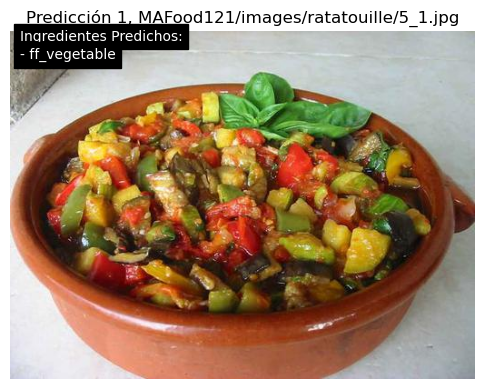

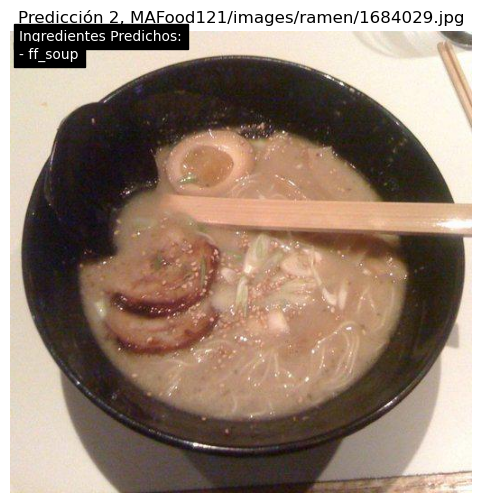

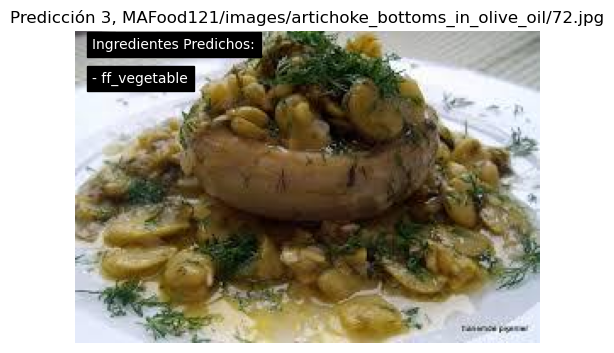

In [24]:
import random
import matplotlib.pyplot as plt

# Mapeo de números de posición a nombres de ingredientes
ingredient_mapping = {
    0: 'ff_bread',
    1: 'ff_dumpling',
    2: 'ff_egg',
    3: 'ff_fried_food',
    4: 'ff_meat',
    5: 'ff_noodles/pasta',
    6: 'ff_rice',
    7: 'ff_seafood',
    8: 'ff_soup',
    9: 'ff_vegetable'
}

# Inference on test
model_path = "best_model.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

# Tomar tres imágenes al azar del conjunto de pruebas
random.seed(2)  # Puedes cambiar la semilla si deseas obtener diferentes imágenes al azar
random_indices = random.sample(range(len(test_df)), 3)

for i, idx in enumerate(random_indices):
    img_data, target = test_dataset[idx]
    img_data = img_data.unsqueeze(0).to(device)
    output = model(img_data)
    output_data = torch.sigmoid(output) >= 0.5
    predicted_ingredient_indices = [i for i in range(len(ing_names)) if output_data[0][i].item() == 1.0]
    predicted_ingredients = [ingredient_mapping[i] for i in predicted_ingredient_indices]

    # Obtener el nombre de la imagen
    image_name = test_df.iloc[idx]['path']

    # Mostrar la imagen y la lista de ingredientes predichos
    image_path = test_df.iloc[idx]['path']
    image = cv2.imread(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicción {i + 1}, {image_name}")
    plt.axis('off')
    
    if predicted_ingredients:
        plt.text(10, 10, "Ingredientes Predichos:", color='white', backgroundcolor='black', fontsize=10)
        for j, ingredient in enumerate(predicted_ingredients):
            plt.text(10, 30 + j * 20, f"- {ingredient}", color='white', backgroundcolor='black', fontsize=10)
    else:
        plt.text(10, 30, "No se detectaron ingredientes", color='white', backgroundcolor='black', fontsize=10)
    
    plt.show()


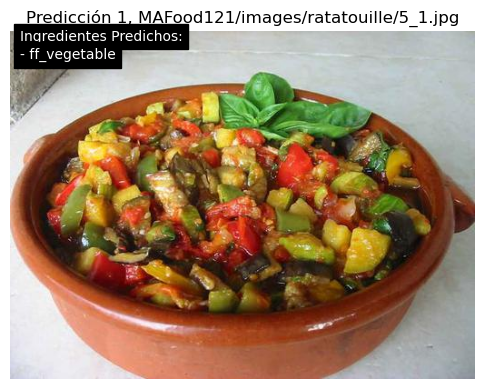

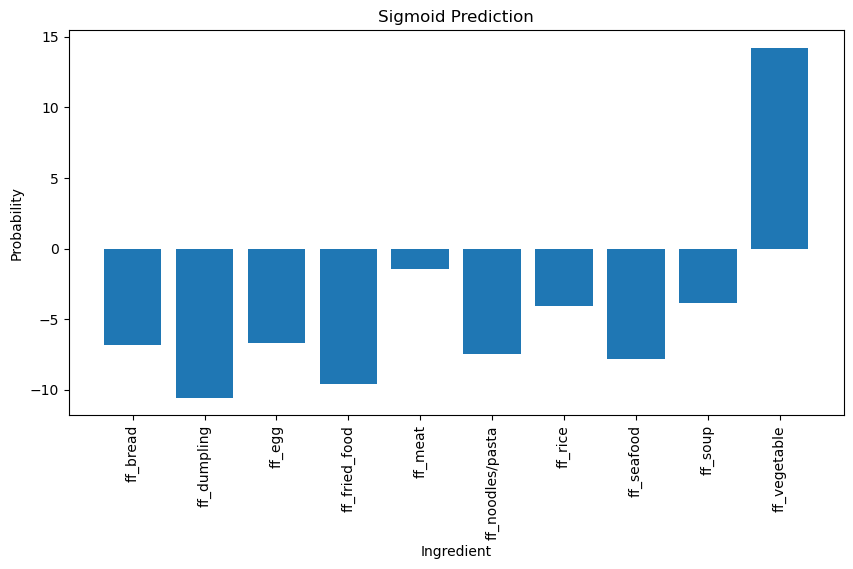

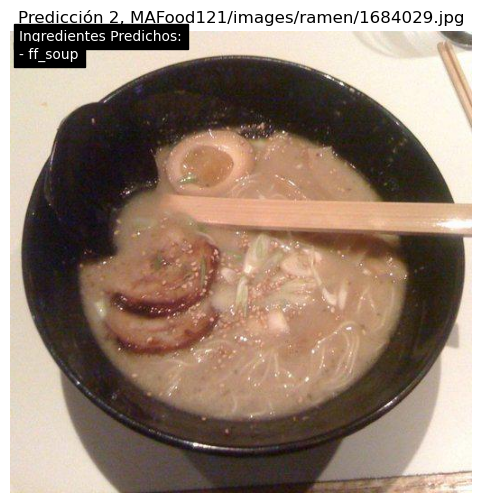

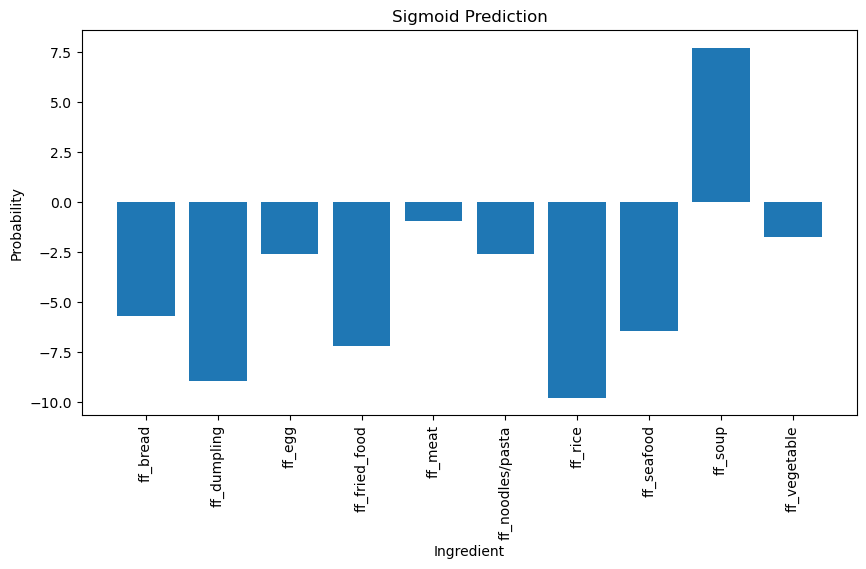

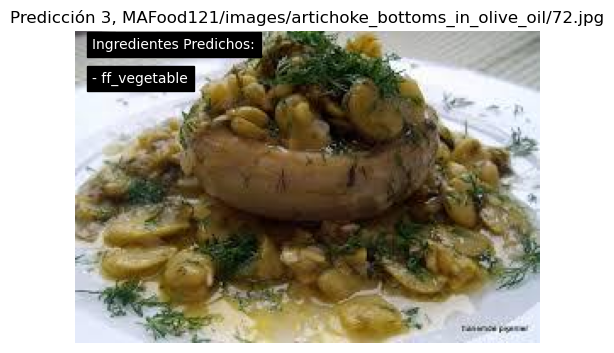

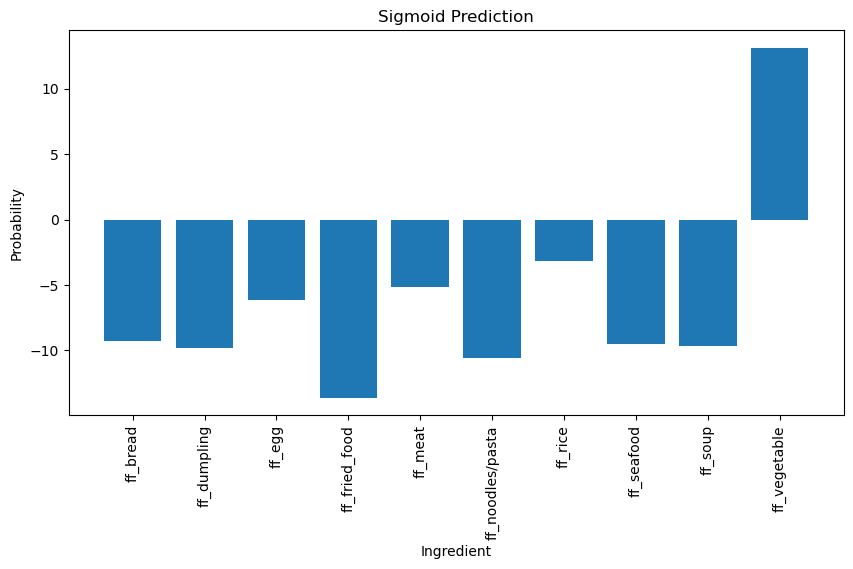

In [25]:
import random
import matplotlib.pyplot as plt
import cv2
import torch

# ... (Código anterior) ...

# Itera a través de los índices aleatorios y realiza lo siguiente para cada imagen:
for i, idx in enumerate(random_indices):
    img_data, target = test_dataset[idx]
    img_data = img_data.unsqueeze(0).to(device)

    # Realiza una inferencia con el modelo para obtener la salida
    output = model(img_data)
    output_data = torch.sigmoid(output) >= 0.5
    predicted_ingredient_indices = [i for i in range(len(ing_names)) if output_data[0][i].item() == 1.0]
    predicted_ingredients = [ingredient_mapping[i] for i in predicted_ingredient_indices]

    # Obtener el nombre de la imagen
    image_name = test_df.iloc[idx]['path']

    # Mostrar la imagen
    image_path = test_df.iloc[idx]['path']
    image = cv2.imread(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicción {i + 1}, {image_name}")
    plt.axis('off')

    if predicted_ingredients:
        plt.text(10, 10, "Ingredientes Predichos:", color='white', backgroundcolor='black', fontsize=10)
        for j, ingredient in enumerate(predicted_ingredients):
            plt.text(10, 30 + j * 20, f"- {ingredient}", color='white', backgroundcolor='black', fontsize=10)
    else:
        plt.text(10, 30, "No se detectaron ingredientes", color='white', backgroundcolor='black', fontsize=10)

    # Obtener las predicciones del modelo
    with torch.no_grad():
        ml_preds = model(img_data)  # sl_preds, ml_preds = model(img_data)

    ml_preds = ml_preds.cpu().numpy()
    ml_preds = ml_preds.squeeze()

    plt.figure(figsize=(10, 5))
    plt.bar(base_ing, ml_preds)
    plt.title('Sigmoid Prediction')
    plt.xticks(rotation=90)
    plt.xlabel('Ingredient')
    plt.ylabel('Probability')
    plt.show()
